## Check the induction head mechanism

In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import pickle
import sys
import subprocess
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

import torch

from data import generate_data
from models.transformer import Transformer, TransformerConfig

sys.path.append(str(Path("..").resolve()))

plt.rc("font", family="serif", size=8)

WIDTH = 8.5  # inches (from ICML style file)
HEIGHT = 8.5 / 1.5  # golden ratio

rc("font", family="serif", size=8)
usetex = not subprocess.run(["which", "pdflatex"]).returncode
rc("text", usetex=usetex)
if usetex:
    rc("text.latex", preamble=r"\usepackage{times}")

/home/awx1303337/miniforge3/envs/dev/lib/python3.12/site-packages/numpy/_core/getlimits.py:545: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


### Visualization of the attention matrices

In [ ]:
save_dir = Path("..").resolve() / "results"

# Generate data
vocab_size = 10
bsz = 32
length = 128
data = generate_data(vocab_size, bsz, length)

# Load model
config = TransformerConfig(
    vocab_size=vocab_size,
    emb_dim=512,
    seq_len=length,
    n_head=1,
    n_layer=2,
)
model = Transformer(config)
checkpoint = torch.load(save_dir / "Adam.pt", map_location=torch.device("cpu"))
model.load_state_dict(checkpoint)

# Recover attention matrices
with torch.no_grad():
    _, attns = model(data.to(torch.long), verbose=True)
    attns = attns.detach().cpu().numpy()
    data = data.numpy()

In [ ]:
N = 10
attns1 = attns[0, :, 0, :N, :N]
attns2 = attns[1, :, 0, N - 1, :N]

In [ ]:
# Create matrix with one on the subdiagonal
N = 10
A = np.diagflat(np.ones(N - 1), k=-1)
attns1 = np.tile(A, (100, 1, 1))
attns2 = np.tile(A, (100, 1, 1))
attns1.shape

(100, 10, 10)

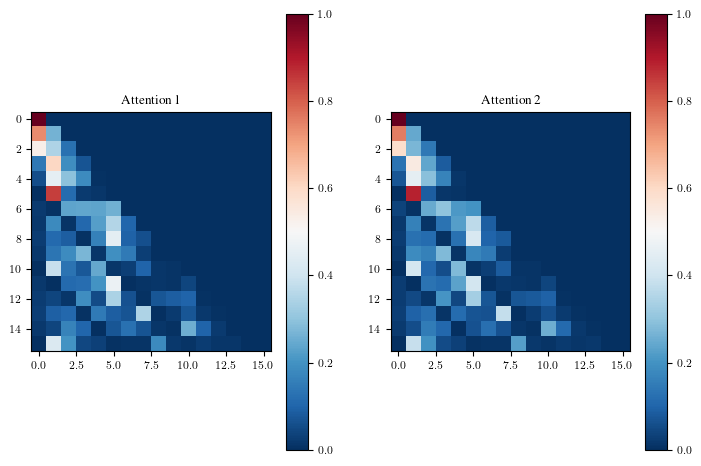

In [ ]:
# usual visualization
N = 16
# plot attention
plt.figure(figsize=(WIDTH, HEIGHT))
plt.subplot(121)
plt.imshow(attns[0, 0, 0, :N, :N], cmap="RdBu_r")
plt.colorbar()
plt.title("Attention 1")
plt.subplot(122)
plt.imshow(attns[0, 1, 0, :N, :N], cmap="RdBu_r")
plt.colorbar()
plt.title("Attention 2")
plt.show()

### Evolution of metrics along training

In [3]:
## path to the current directory of this jupyter notebook
directory = Path("..").resolve() / "results"
all_losses = pickle.load(open(directory / "losses.pkl", "rb"))
all_accs = pickle.load(open(directory / "accs.pkl", "rb"))
all_attn1 = pickle.load(open(directory / "attn1.pkl", "rb"))
all_attn2 = pickle.load(open(directory / "attn2.pkl", "rb"))

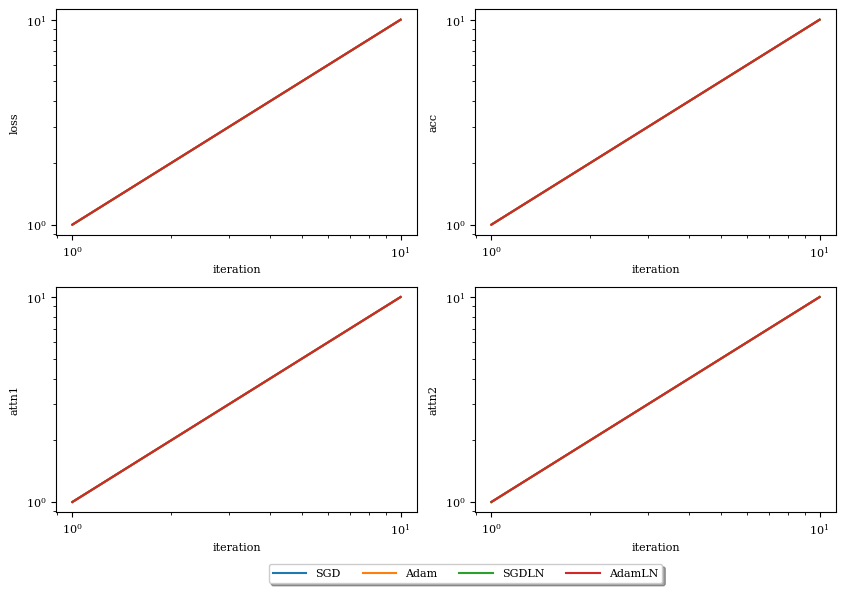

In [15]:
names = ["SGD", "Adam", "SGDLN", "AdamLN"]
niter = len(all_losses["SGD"])

fig, axes = plt.subplots(2, 2, figsize=(WIDTH, HEIGHT))
ax = axes[0, 0]
for i, name in enumerate(names):
    ax.loglog(np.arange(niter) + 1, all_losses[name], label=name)
    ax.set_xlabel("iteration")
    ax.set_ylabel("loss")

ax = axes[0, 1]
for i, name in enumerate(names):
    ax.loglog(np.arange(niter) + 1, all_accs[name], label=name)
    ax.set_xlabel("iteration")
    ax.set_ylabel("acc")

ax = axes[1, 0]
for i, name in enumerate(names):
    ax.loglog(np.arange(niter) + 1, all_accs[name], label=name)
    ax.set_xlabel("iteration")
    ax.set_ylabel("attn1")

ax = axes[1, 1]
for i, name in enumerate(names):
    ax.loglog(np.arange(niter) + 1, all_accs[name], label=name)
    ax.set_xlabel("iteration")
    ax.set_ylabel("attn2")

lines_labels = [fig.axes[1].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(
    lines,
    labels,
    loc="upper center",
    bbox_to_anchor=(0.55, 0),
    fancybox=True,
    borderaxespad=0,
    shadow=True,
    ncol=4,
    handlelength=3,
)
plt.tight_layout()
plt.show()